**Quantitative X-Ray Imaging: Tutorial 02**   
*Julia Herzen, Franziska Hinterdobler, Sara Savatović, Sami Wirtensohn*   

# X-ray interaction with matter

From our undergraduate electrodynamics lecture, we know that a plane wave traversing a medium is given by:
$$
\psi(\vec{r}) = \psi_0 \cdot e^{i \, n(\vec{k} \cdot \vec{r})}
$$
with $\psi_0$ being the amplitude, $\vec{k}$ the wave vector, $n$ the complex refractive index and $\vec{r}$ the position. The complex refractive index is defined by
$$
n = (1-\delta) + i\beta.
$$
The real part of the complex refractive index $(1-\delta)$ corresponds to the refractive properties of the sample and the imaginary part $(\beta)$ to its transmission properties. If the direction of propagation is $z$, we can write
$$
    \psi(z) = \psi_0 \cdot
                    \underbrace{e^{ik z}}_{\substack{\text{propagation} \\ \text{in vacuum}}} \cdot \underbrace{e^{-i\delta k z}}_\text{refraction} \cdot 
                    \underbrace{e^{-\beta k z}}_\text{attenuation}.
$$
The complex refractive index $n=n(E)$ is different for each material and depends on the energy of the interacting electromagnetic radiation. 
Tabulated values can be found for most of the common materials in the NIST (National Institute of Standards and Technology) [database](https://www.nist.gov/pml/x-ray-mass-attenuation-coefficients). We will use the Python package `xraylib`, which is based on these tabulated values, in the following example to gain a deeper understanding of X-ray interaction with matter. 

Let's start by importing useful Python libraries and defining some visualization parameters.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scipy.ndimage as ndi
import xraylib

# Visualization method inline (non-interactive) and widget (interactive, requires ipympl)
# or with qt (opens new window)
%matplotlib widget

# Set some global plotting properties
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['figure.figsize'] = (10,5)
matplotlib.rcParams['figure.dpi'] = 100

If the interactive mode using `widget` is not working it probably needs the package `ipympl`. Install it by running `!conda install conda-forge::ipympl` in a cell and restart the Jupyter Notebook after installation. When changing from `widget` to `inline`, restart the kernel and run the cells again.

### Part 1: Complex refractive index

We can use `xraylib` to get some information about the properties of gold *Au* at an energy of 10 keV, knowing it's normal density is 19.3 g/cm3:

In [2]:
E = 10 # in keV
density = 19.3 # in g/cm^3
n = xraylib.Refractive_Index("Au", E, density)
print('n = ', n)

n =  (0.9999703199596893+2.2494574733581103e-06j)


As you can see, we obtain the real and complex part of the complex refractive index $n$, which can be used to simulate X-ray & material interactions.

Retrieving the densities and $n$ for compound materials manually is quite time-consuming. 
Luckily, `xraylib` has a database for the most common compounds, and we define a function that helps us retrieving the real and complex parts of the refractive index, namely $\delta$ and $\beta$.

In [3]:
def get_n(name, E, density=None):
    """
    Get compound refractive index values: beta, delta, mu.

    Parameters
    ----------
    name : string
        Compound chemical composition or compound name from the list
        xraylib.GetCompoundDataNISTList().
    E : array
        Energy or list of energies in keV.
    density : float, optional
        Density of the compound in g/cm³. If the compound is from the
        NISTList it is not required. Check compound specifications with 
        xraylib.GetCompoundDataNISTByName(name)

    Returns
    ----------
    out : dictionary
        Values in dictionary entries "name", beta", "delta", "mu". mu is given in 1/m, which is
        different than what we get from CS_Total_CP()*density (1/cm).
    """
        
    if density is None:
        try:
            density = xraylib.GetCompoundDataNISTByName(name)['density']
        except:
            print('Specify density, compound not in NIST database.')
            return

    def _n(name, E, density):
        beta  = xraylib.Refractive_Index_Im(name, E+.0, density)
        delta = 1 - xraylib.Refractive_Index_Re(name, E+.0, density)
        lam = xraylib.KEV2ANGST * 1e-10 / E  # in m
        mu = beta * 4 * np.pi / lam # in 1/m
        return dict(name=name, beta=beta, delta=delta, mu=mu)

    if np.ndim(E)==0:
        E = [E]
    compound = np.array([_n(name, e, density)['name'] for e in E]).squeeze()
    beta = np.array([_n(name, e, density)['beta'] for e in E]).squeeze()
    delta = np.array([_n(name, e, density)['delta'] for e in E]).squeeze()
    mu = np.array([_n(name, e, density)['mu'] for e in E]).squeeze()
    out = dict(name=compound, beta=beta, delta=delta, mu=mu)

    return out

def disc_mask(sh, ctr, R):
    """
    Returns disc mask of radius R, centered in ctr, for an image of shape sh.
    """
    i0, i1 = np.indices(sh, dtype=float) - np.array(ctr)[:, np.newaxis, np.newaxis]
    r2 = (i0/R)**2 + (i1/R)**2
    return (r2 <= 1.)

def imsh(img, p=5, vmin=None, vmax=None):
    """
    Function to show images with automatic windowing.
    """
    if not vmin: vmin=np.percentile(img, p)
    if not vmax: vmax=np.percentile(img, 100-p)
    plt.imshow(img, vmin=vmin, vmax=vmax)

You can list the available compounds in the database using the following:

In [4]:
xraylib.GetCompoundDataNISTList()

('A-150 Tissue-Equivalent Plastic',
 'Acetone',
 'Acetylene',
 'Adenine',
 'Adipose Tissue (ICRP)',
 'Air, Dry (near sea level)',
 'Alanine',
 'Aluminum Oxide',
 'Amber',
 'Ammonia',
 'Aniline',
 'Anthracene',
 'B-100 Bone-Equivalent Plastic',
 'Bakelite',
 'Barium Fluoride',
 'Barium Sulfate',
 'Benzene',
 'Beryllium oxide',
 'Bismuth Germanium oxide',
 'Blood (ICRP)',
 'Bone, Compact (ICRU)',
 'Bone, Cortical (ICRP)',
 'Boron Carbide',
 'Boron Oxide',
 'Brain (ICRP)',
 'Butane',
 'N-Butyl Alcohol',
 'C-552 Air-Equivalent Plastic',
 'Cadmium Telluride',
 'Cadmium Tungstate',
 'Calcium Carbonate',
 'Calcium Fluoride',
 'Calcium Oxide',
 'Calcium Sulfate',
 'Calcium Tungstate',
 'Carbon Dioxide',
 'Carbon Tetrachloride',
 'Cellulose Acetate, Cellophane',
 'Cellulose Acetate Butyrate',
 'Cellulose Nitrate',
 'Ceric Sulfate Dosimeter Solution',
 'Cesium Fluoride',
 'Cesium Iodide',
 'Chlorobenzene',
 'Chloroform',
 'Concrete, Portland',
 'Cyclohexane',
 '1,2-Ddihlorobenzene',
 'Dichlorodi

As mentioned earlier, **the complex refractive index changes with X-ray energy**. Let's define an energy range from $10 keV$ to $130 keV$ and  try to see how it changes for different materials, i.e., aluminum *Al*, lead *Pb*, iodine *I*, water, *PE* (polyethylene), *POM* (polyoxymethylene) and *PMMA* (polymethyl methacralate). It is also possible to enter chemical formulas, e.g. "CH2O" (Formaldehyde).

In [5]:
E = np.arange(10,130,10)
al = get_n('Al', E, 2.7) # aluminum density 2.7 g/cm³
pb = get_n('Pb', E, 11.34)
iod = get_n('I', E, 4.93)
water = get_n('Water, Liquid', E)
pe = get_n('Polyethylene', E)
pom = get_n('Polyoxymethylene', E)
pmma = get_n('Polymethyl Methacralate (Lucite, Perspex)', E)

The data is now stored in a dictionary `{}`. You can access the data by using `keys`. For how be built our `get_n` function, our data have four keys: 'name', 'beta', 'delta', 'mu'.

In [6]:
# shows the delta value of n for each energy in E
print('delta: ', pmma['delta'])
print('beta: ', pmma['beta'])

delta:  [2.67062965e-06 6.66349752e-07 2.96026236e-07 1.66486584e-07
 1.06542831e-07 7.39846907e-08 5.43545783e-08 4.16144695e-08
 3.28801607e-08 2.66326933e-08 2.20103455e-08 1.84947115e-08]
beta:  [3.94154254e-09 3.35461811e-10 1.18667357e-10 6.89848485e-11
 4.87023602e-11 3.76464172e-11 3.06102044e-11 2.57009992e-11
 2.20669849e-11 1.92653737e-11 1.70399626e-11 1.52306353e-11]


Plot $\delta$ and $\beta$ over the energy.

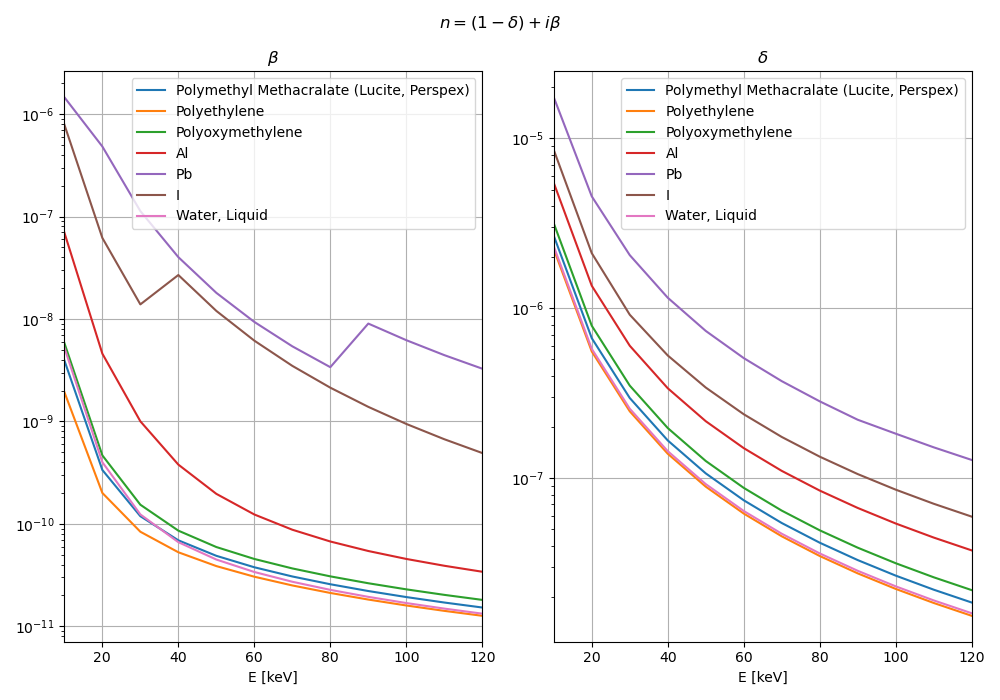

In [7]:
plt.figure(figsize=(10,7))
plt.suptitle(r'$n=(1-\delta)+i\beta$')
plt.subplot(121)
plt.title(r'$\beta$')
plt.plot(E, pmma['beta'], label=pmma['name'][0])
plt.plot(E, pe['beta'], label=pe['name'][0])
plt.plot(E, pom['beta'], label=pom['name'][0])
plt.plot(E, al['beta'], label=al['name'][0])
plt.plot(E, pb['beta'], label=pb['name'][0])
plt.plot(E, iod['beta'], label=iod['name'][0])
plt.plot(E, water['beta'], label=water['name'][0])
plt.xlabel('E [keV]')
plt.grid('major')
plt.xlim(10,120)
plt.legend()
plt.semilogy()

plt.subplot(122)
plt.title(r'$\delta$')
plt.plot(E, pmma['delta'], label=pmma['name'][0])
plt.plot(E, pe['delta'], label=pe['name'][0])
plt.plot(E, pom['delta'], label=pom['name'][0])
plt.plot(E, al['delta'], label=al['name'][0])
plt.plot(E, pb['delta'], label=pb['name'][0])
plt.plot(E, iod['delta'], label=iod['name'][0])
plt.plot(E, water['delta'], label=water['name'][0])
plt.xlabel('E [keV]')
plt.grid('major')
plt.xlim(10,120)
plt.legend()
plt.semilogy()

plt.tight_layout()


### Part 2: Image formation
The relationship between the wavefield $\psi$ and the intensity $I$ recorded by the detector depends on the specific imaging system and the properties of the waves involved. However, a common relationship is given by the intensity being proportional to the square of the magnitude of the wavefield. Knowing the definitions from the beginning of this notebook, we obtain the Lambert-Beer law. 
$$
I \propto |\psi|^2 = |\psi_{0}|^2 \, e^{-2\beta k z} = I_{0} \, e^{-\mu z}
$$
Here, $\mu=\mu(E)$ is the linear attenuation coefficient. It can be expressed in function of the real part of the refractive index $\beta$. Knowing that $\lambda$ is the wavelength and $k=2\pi/\lambda$ the wave number we get that:
$$
\mu = \frac{4\pi\beta}{\lambda}
$$
Thus, $\mu$ changes with energy and material. It can be calculated using `xraylib`.

Now, let's generate a test object (phantom) at e.g. $40keV$ and generate images we would typically see on our detector. Generate a phantom filled with purely attenuating samples ($\mu$) and the same sample filled with purely phase samples ($\delta$).

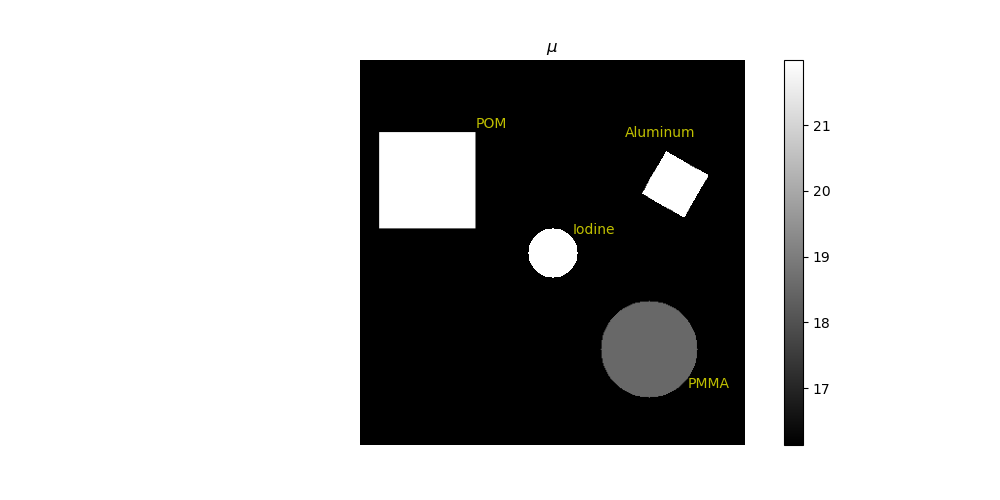

In [8]:
# at 40 keV
E0 = -1 #E[3]
quantity = 'mu'
sh = (400,400)
phantom = np.ones(sh) * water[quantity][E0]
mask_iod = disc_mask(sh, (200,200), 25)
mask_pmma = disc_mask(sh, (300,300), 50)
mask_pom = np.zeros_like(phantom, dtype=bool)
mask_pom[75:175,20:120] = True
mask_al = np.zeros_like(phantom, dtype=bool)
mask_al[50:100,250:300] = True
mask_al = ndi.rotate(mask_al, -30, order=0, reshape=False).astype(bool)
phantom[mask_iod] = iod[quantity][E0]
phantom[mask_pmma] = pmma[quantity][E0]
phantom[mask_pom] = pom[quantity][E0]
phantom[mask_al] = al[quantity][E0]

plt.figure()
plt.title(r'$\mu$')
imsh(phantom)
plt.text(220, 180, 'Iodine', c='y')
plt.text(340, 340, 'PMMA', c='y')
plt.text(120, 70, 'POM', c='y')
plt.text(275, 80, 'Aluminum', c='y')
plt.axis('off')
plt.colorbar()

Let's say this is an axial slice of the phantom and build the whole 3D volume by stacking the same image $\times300$.

In [9]:
phantom_3d = np.stack(300*[phantom], axis=0)

In [10]:
phantom_3d.shape

(300, 400, 400)

The first axis is the height of the phantom. Show a slice in the center of the volume, and show what the detector would record if placed along `axis=1`. For a volume with $\mu(x,y,z)$, the detector sees the following $I=I_{0}\,e^{-\int_{V}\mu\,dV }$ and we generated maps of $\mu$.

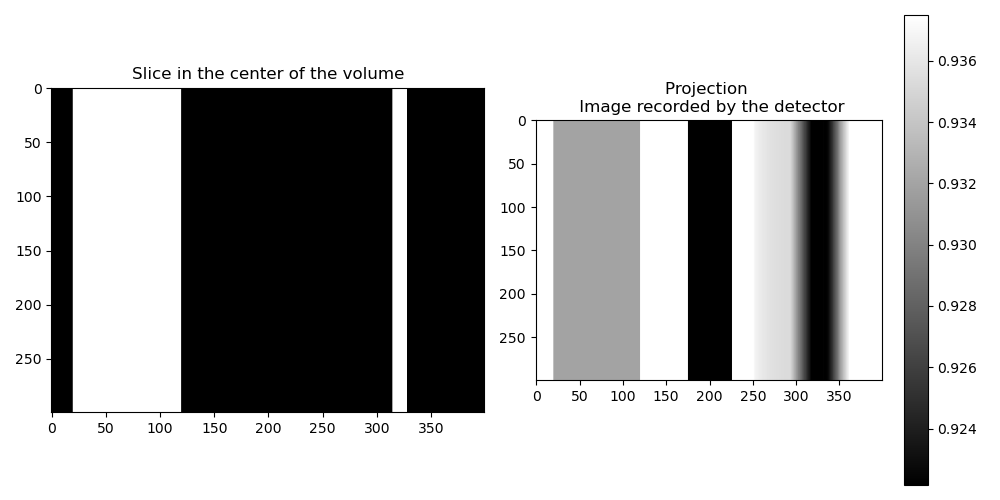

In [11]:
# decide on a pixel size, e.g. 1 pixel = 1µm
px_size = 10e-6
# assume I0 = 1
proj = np.exp(-phantom_3d.sum(axis=1)*px_size)

plt.figure()
plt.subplot(121)
plt.title('Slice in the center of the volume')
imsh(phantom_3d[:,100,:])

plt.subplot(122)
plt.title('Projection \n Image recorded by the detector')
imsh(proj,15)
plt.colorbar()

plt.tight_layout()

The quality of the image recorded by the detector will depend on the number of photons recorded at each pixel.
Noise can arise from the statistical nature of photon interactions with the detector. The **Poisson distribution** describes the probability of detecting a certain number of photons in a given time interval or spatial region. Photon noise increases with lower intensity $I_{0}$ levels.

Let's see how it affects the image using `np.random.poisson`. Define a function which normalizes the projection and add a factor `I0` which scales the incident intensity (e.g., $10^{5}$ photons). See how the quality of image degrades for lower `I0`.

In [12]:
def add_poisson_noise(img, I0=1):
    noisy = np.random.poisson(I0 * 1e5 * img) # multiply with photon count to apply poisson statistics
    out = noisy / (I0 * 1e5)
    return out

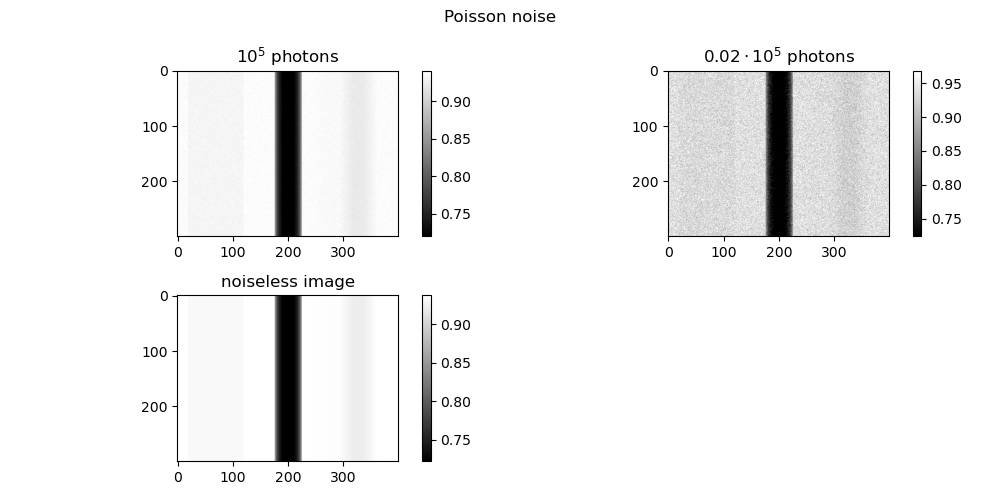

In [13]:
proj1 = add_poisson_noise(proj, I0=1)
proj07 = add_poisson_noise(proj, I0=0.02)

plt.figure()

plt.suptitle('Poisson noise')
plt.subplot(221)
plt.title(r'$10^5$ photons')
imsh(proj1)#, vmin=0.01, vmax=0.09)
plt.colorbar()

plt.subplot(222)
plt.title(r'$0.02 \cdot 10^5$ photons')
imsh(proj07)#,vmin = 0.01, vmax = 1)#, vmin=0.01, vmax=0.09)
plt.colorbar()

plt.subplot(223)
plt.title(r'noiseless image')
imsh(proj)#, vmax = 1.0)
plt.colorbar()

plt.tight_layout()

### Part 3: Energy dependence 

To make things easier, let's define a function that builds a 3D phantom for a given energy and can return values of "beta", "delta", or "mu".

In [14]:
def make_phantom(E, quantity='beta'):
    """
    Build a 3D test object of shape "sh" made of circular insets of iodine 
    and PMMA and a POM and aluminum square inset in a water background.

    Parameters
    ----------
    E : double
        Energy in keV.
    quantity : str, optional
        Refractive index quantity to represent: "beta", "delta", "mu".

    Returns
    ----------
    out : 3d array
        Volume.
    """
    sh = (300,400,400)
    phantom = np.ones(sh[1:]) * get_n('Water, Liquid', E)[quantity]
    mask_iod = disc_mask(sh[1:], (200,200), 25) 
    mask_pmma = disc_mask(sh[1:], (300,300), 50) 
    mask_pom = np.zeros_like(phantom, dtype=bool)
    mask_pom[75:175,20:120] = True
    mask_al = np.zeros_like(phantom, dtype=bool)
    mask_al[50:100,250:300] = True
    mask_al = ndi.rotate(mask_al, -30, order=0, reshape=False).astype(bool)
    phantom[mask_iod] = get_n('I', E, 4.93)[quantity]
    phantom[mask_pmma] = get_n('Polymethyl Methacralate (Lucite, Perspex)', E)[quantity]
    phantom[mask_pom] = get_n('Polyoxymethylene', E)[quantity]
    phantom[mask_al] = get_n('Al', E, 2.7)[quantity]
    out = np.stack(sh[0]*[phantom], axis=0)
    return out

Generate the transmission phantoms at $30 keV$ and $40 keV$ and compare an axial slice. Look at the ratio of the two and check the values for `quantity='mu'`.

In [15]:
# transmission phantom
phtm_Tm_30 = make_phantom(30, quantity='mu')
phtm_Tm_40 = make_phantom(40, quantity='mu')
# phase phantom
phtm_Ph_30 = make_phantom(30, quantity='delta')
phtm_Ph_40 = make_phantom(40, quantity='delta')

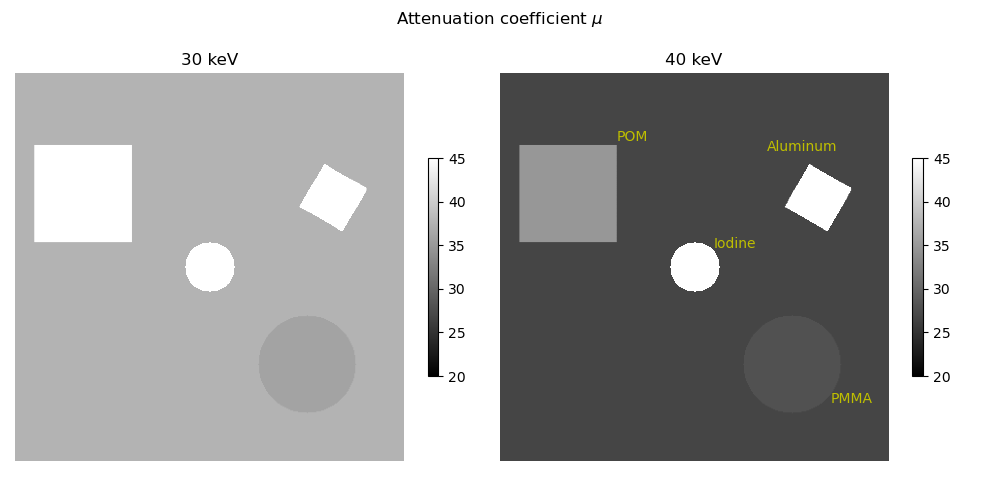

In [16]:
plt.figure()

plt.suptitle(r'Attenuation coefficient $\mu$')
plt.subplot(121)
plt.title('30 keV')
imsh(phtm_Tm_30[150], vmin=20, vmax=45)
plt.axis('off')
plt.colorbar(shrink=0.5)

plt.subplot(122)
plt.title('40 keV')
imsh(phtm_Tm_40[150], vmin=20, vmax=45)
plt.axis('off')
plt.colorbar(shrink=0.5)
plt.text(220, 180, 'Iodine', c='y')
plt.text(340, 340, 'PMMA', c='y')
plt.text(120, 70, 'POM', c='y')
plt.text(275, 80, 'Aluminum', c='y')

plt.tight_layout()

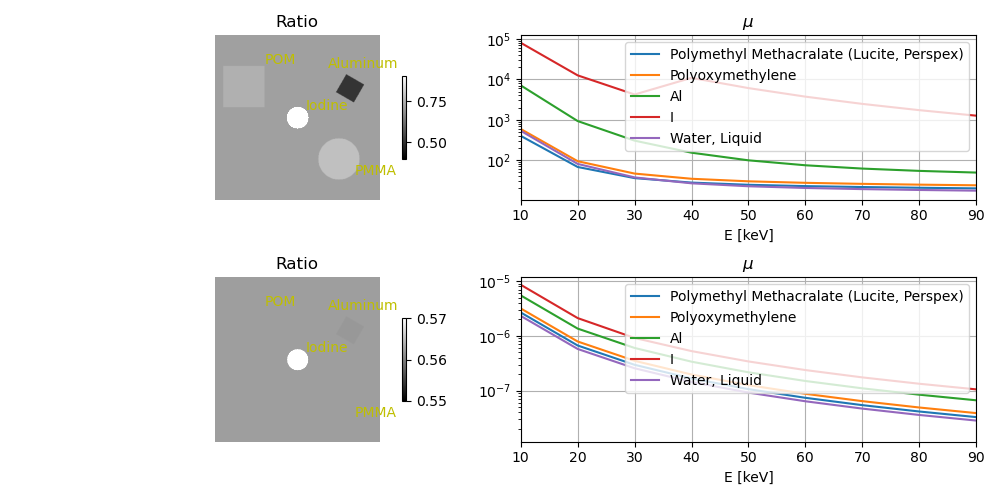

In [19]:
plt.figure()

plt.subplot(221)
plt.title('Ratio')
imsh(phtm_Tm_40[150]/phtm_Tm_30[150], vmin=0.4, vmax=0.9)
plt.axis('off')
plt.colorbar(shrink=0.5)
plt.text(220, 180, 'Iodine', c='y')
plt.text(340, 340, 'PMMA', c='y')
plt.text(120, 70, 'POM', c='y')
plt.text(275, 80, 'Aluminum', c='y')

plt.subplot(222)
plt.title(r'$\mu$')
plt.plot(E, pmma['mu'], label=pmma['name'][0])
plt.plot(E, pom['mu'], label=pom['name'][0])
plt.plot(E, al['mu'], label=al['name'][0])
plt.plot(E, iod['mu'], label=iod['name'][0])
plt.plot(E, water['mu'], label=water['name'][0])
plt.xlabel('E [keV]')
plt.grid('major')
plt.xlim(10,90)
plt.legend()
plt.semilogy()

plt.subplot(223)
plt.title('Ratio')
imsh(phtm_Ph_40[150]/phtm_Ph_30[150], vmin=0.55, vmax=0.57)
plt.axis('off')
plt.colorbar(shrink=0.5)
plt.text(220, 180, 'Iodine', c='y')
plt.text(340, 340, 'PMMA', c='y')
plt.text(120, 70, 'POM', c='y')
plt.text(275, 80, 'Aluminum', c='y')

plt.subplot(224)
plt.title(r'$\delta$')
plt.plot(E, pmma['delta'], label=pmma['name'][0])
plt.plot(E, pom['delta'], label=pom['name'][0])
plt.plot(E, al['delta'], label=al['name'][0])
plt.plot(E, iod['delta'], label=iod['name'][0])
plt.plot(E, water['delta'], label=water['name'][0])
plt.xlabel('E [keV]')
plt.grid('major')
plt.xlim(10,90)
plt.legend()
plt.semilogy()
plt.tight_layout()

Now generate the phantom at $70 keV$ for `quantity='mu'` and `quantity='delta'`. 

In [20]:
phtm_T_70 = make_phantom(70, quantity='mu')
phtm_phase_70 = make_phantom(70, quantity='delta')

Look at the projections along `axis=2` and plot a horizontal line through the projections. We also normalize the projection with an empty projection (flat field) that only contains water.Assume the Lambert-Beer law works the same for $\delta$ when generating the detector image.

In [21]:
# assume 10mu px size
px_size = 10e-6
proj_T_70 = np.exp(- np.sum(phtm_T_70, axis=2)*px_size)
proj_phase_70 = np.exp(-np.sum(phtm_phase_70, axis=2)*px_size)

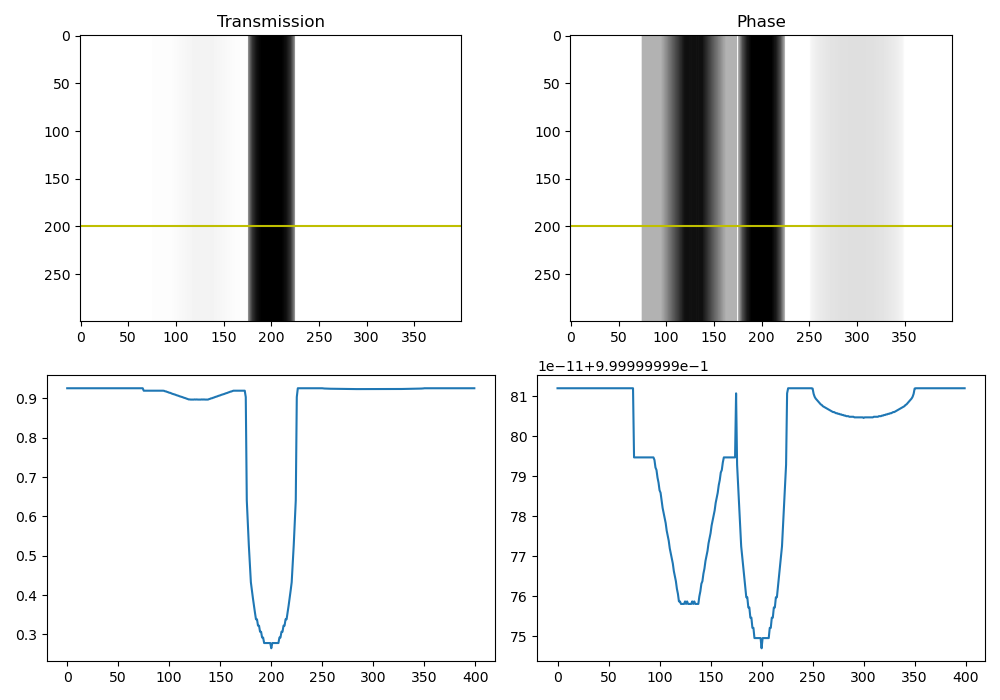

In [22]:
plt.figure(figsize=(10,7))

plt.subplot(221)
plt.title('Transmission')
imsh(proj_T_70)
plt.axhline(200, c='y')

plt.subplot(222)
plt.title('Phase')
imsh(proj_phase_70)
plt.axhline(200, c='y')

plt.subplot(223)
plt.plot(proj_T_70[200])

plt.subplot(224)
plt.plot(proj_phase_70[200])

plt.tight_layout()